2018 Edition

# Building a music recommender system

As its name implies, a recommender system is a tool that helps predicting what a user may or may not like among a list of given items. In some sense, you can view this as an alternative to content search, as recommendation engines help users discover products or content that they may not come across otherwise. For example, Facebook suggests friends and pages to users. Youtube recommends videos which users may be interested in. Amazon suggests the products which users may need... Recommendation engines engage users to services, can be seen as a revenue optimization process, and in general help maintaining interest in a service.

In this notebook, we study how to build a simple recommender system: we focus on music recommendations, and we use a simple algorithm to predict which items users might like, that is called ALS, alternating least squares.

## Goals

In this lecture, we expect students to:

- Revisit (or learn) recommender algorithms

- Understand the idea of Matrix Factorization and the ALS algorithm (serial and parallel versions)

- Build a simple model for a real usecase: music recommender system

- Understand how to validate the results

## Steps

We assume students to work outside lab hours on the learning material. These are the steps by which we guide students, during labs, to build a good basis for the end-to-end development of a recommender system:

* Inspect the data using Spark SQL, and build some basic, but very valuable knowledge about the information we have at hand
* Formally define what is a sensible algorithm to achieve our goal: given the "history" of user taste for music, recommend new music to discover. Essentialy, we want to build a statistical model of user preferences such that we can use it to "predict" which additional music the user could like
* With our formal definition at hand, we will learn different ways to implement such an algorithm. Our goal here is to illustrate what are the difficulties to overcome when implementing a (parallel) algorithm
* Finally, we will focus on an existing implementation, available in the Apache Spark MLLib, which we will use out of the box to build a reliable statistical model

Now, you may think at this point we will be done!

Well, you'd better think twice: one important topic we will cover in all our Notebooks is **how to validate the results we obtain**, and **how to choose good parameters to train models** especially when using an "opaque" library for doing the job. As a consequence, we will focus on the statistical validation of our recommender system.


# 1. Data

Understanding data is one of the most important part when designing any machine learning algorithm. In this notebook, we will use a data set published by Audioscrobbler - a music recommendation system for last.fm. Audioscrobbler is also one of the first internet streaming radio sites, founded in 2002. It provided an open API for “scrobbling”, or recording listeners’ plays of artists’ songs. last.fm used this information to build a powerful music recommender engine.

## 1.1. Data schema

Unlike a rating dataset which contains information about users' preference for products (one star, 3 stars, and so on), the datasets from Audioscrobbler only has information about events: specifically, it keeps track of how many times a user played songs of a given artist and the names of artists. That means it carries less information than a rating: in the literature, this is called explicit vs. implicit ratings.

### Reading material

- [Implicit Feedback for Inferring User Preference: A Bibliography](http://people.csail.mit.edu/teevan/work/publications/papers/sigir-forum03.pdf)
- [Comparing explicit and implicit feedback techniques for web retrieval: TREC-10 interactive track report](http://trec.nist.gov/pubs/trec10/papers/glasgow.pdf)
- [Probabilistic Models for Data Combination in Recommender Systems](http://mlg.eng.cam.ac.uk/pub/pdf/WilGha08.pdf)

The data we use in this Notebook is available in 3 files (these files are stored in our HDFS layer, in the directory  ```/datasets/lastfm```):

- **`user_artist_data.txt`**: It contains about 140,000+ unique users, and 1.6 million unique artists. About 24.2 million users’ plays of artists’ are recorded, along with their count. It has 3 columns separated by spaces: 

| UserID | ArtistID | PlayCount |
|----|----|----|
| ...|...|...|


- **`artist_data.txt`** : It prodives the names of each artist by their IDs. It has 2 columns separated by tab characters (`\t`).

| ArtistID | Name |
|---|---|
|...|...|

- **`artist_alias.txt`**: Note that when plays are scrobbled, the client application submits the name of the artist being played. This name could be misspelled or nonstandard. For example, "The Smiths", "Smiths, The", and "the smiths" may appear as distinct artist IDs in the data set, even though they are plainly the same. `artist_alias.txt` maps artist IDs that are known misspellings or variants to the canonical ID of that artist. The data in this file has 2 columns separated by tab characters (`\t`).

| MisspelledArtistID | StandardArtistID |
|---|---|
|...|...|



## 1.2. Understanding data: simple descriptive statistic

In order to choose or design a suitable algorithm for achieving our goals, given the data we have, we should first understand data characteristics. To start, we import the necessary packages to work with regular expressions, Data Frames, and other nice features of our programming environment.

In [1]:
import os
import sys
import re
import random
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import time

import seaborn as sns

sns.set(palette=sns.color_palette("colorblind", 8),
       style=sns.axes_style("white"))
plt.rcParams["figure.figsize"] = (12, 6)

sqlContext = SQLContext(sc)
base = "/datasets/lastfm/"

### Question 1

#### Question 1.0 (Non-grading)
<div class="alert alert-info">
Using SPARK SQL, load data from `/datasets/lastfm/user_artist_data.txt` and show the first 20 entries (via function `show()`).
</div>

For this Notebook, from a programming point of view, we are given the schema for the data we use, which is as follows:

```
userID: long int
artistID: long int
playCount: int
```

Each line of the dataset contains the above three fields, separated by a "white space".

In [2]:
userArtistDataSchema = StructType([ \
    StructField("userID", LongType(), True), \
    StructField("artistID", LongType(), True), \
    StructField("playCount", IntegerType(), True)])

userArtistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter=' ') \
    .load(base + "user_artist_data.txt", schema = userArtistDataSchema) \
    .cache()

# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
userArtistDF.cache()

userArtistDF.show(20)

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
|1000002| 1000013|        8|
|1000002| 1000014|       42|
|1000002| 1000017|       69|
|1000002| 1000024|      329|
|1000002| 1000025|        1|
|1000002| 1000028|       17|
|1000002| 1000031|       47|
|1000002| 1000033|       15|
|1000002| 1000042|        1|
|1000002| 1000045|        1|
|1000002| 1000054|        2|
|1000002| 1000055|       25|
|1000002| 1000056|        4|
|1000002| 1000059|        2|
|1000002| 1000062|       71|
+-------+--------+---------+
only showing top 20 rows



#### Question 1.1: 
<div class="alert alert-info">
How many distinct users do we have in our data? 
</div>

In [3]:
uniqueUsers = userArtistDF.select("UserID").distinct().count()
print("Total n. of users: ", uniqueUsers)

Total n. of users:  148111


#### Answer
<div class="alert alert-success">
<p>
    There are approximately 150k distinct users, which is enough to use a statistical approach as we will do later in this notebook.
</p>
<p>
    A too few number of users would not have been sufficient to predict accurately users tastes as all the sensitivities would not have been represented in the dataset.
</p>
<p>
    Furthermore, a huge number of distinct and various users reduces the risk of overfitting if those users have a huge variety of tastes. In fact this widens the range of features that can be predicted accurately using a <b>Collaborative-based system</b> (this will be the case in this notebook because <b>content-based systems</b> needs more features as there is in the dataset for artists (for instance, it would have been accurate to include the genre, the year, or even the main language of the artist).
</p>
</div>

#### Additional question

<div class="alert alert-info">
What is the average number of entries per user ?
</div>

In [4]:
entriesPerUser = userArtistDF.select("UserID").count()//\
    userArtistDF.select("UserID").distinct().count()#Floored
print("Average user entries: ", entriesPerUser)

Average user entries:  164


#### Answer
<div class="alert alert-success">
<p>
    The more entries there will be per user, the less sparse (<i>warmer</i>) the utility matrix will be and therefore the more the recommandation will be accurate (it also improves the risk of overfitting). 
</p>
<p>
This is what happend when we gather people in groups of interest to improve the prediction on preferences : this is reducing the number of artists to take into account (is nobody in the group ever heard/rated an artist, there is no need to include it in the matrix and it therefore reduces the number of it). The goal is obviously to have a more dense matrix, easier to exploit.
</p>
<p>
Generaly speaking, on a huge dataset, the number of feature per observation is relatively slow, leading to a pretty sparse matrix and a huge degree of liberty predicting good results: there is a lot of uncertainty.
</p>

<p>
Another important thing to take into account is (cf question 3.2) that artists may be mispelled or non-standard and therefore the matrix may be way less sparse. This is the reason why we don't compare the number of entries per user to the number of artists for now.
</p>

</div>

#### Question 1.2
<div class="alert alert-info">
How many distinct artists do we have in our data ?
</div>

In [5]:
uniqueArtists = userArtistDF.select("ArtistID").distinct().count()
print("Total n. of artists: ", uniqueArtists)

Total n. of artists:  1631028


#### Answer
<div class="alert alert-success">
<p>
    In the opposite of the number of Users, the number of artists increases the sparsity of the utility matrix in the case of collaborative-based system and therefore makes predictions less accurate. A system is capable of better prediction in a smaller set of products.
</p>
<p>
    But here, as we will see later in this notebook, the number of distinct artists is not right: artists may have been mispelled in that dataset.
</p>
</div>

#### Question 1.3
<div class="alert alert-info">
One limitation of Spark MLlib's ALS implementation - which we will use later - is that it requires IDs for users and items to be nonnegative 32-bit integers. This means that IDs larger than `Integer.MAX_VALUE`, or `2147483647`, can't be used. So we need to check whether this data set conforms to the strict requirements of our library.  

What are the maximum and minimum values of column `userID` ?  
</div>

In [6]:
maxUserID = (userArtistDF.select(max("UserID"))
             # The returned tab is of len 1
             .collect()[0]
             # Easier to process as a dictionnary
             .asDict()["max(UserID)"])

print("The maximum user ID is ", 
      maxUserID, 
      " <= " if maxUserID <= 2147483647 else " > ",
      "Integer.MAX_VALUE")

The maximum user ID is  2443548  <=  Integer.MAX_VALUE


In [7]:
minUserID = (userArtistDF.select(min("UserID"))
             # The returned tab is of len 1
             .collect()[0]
             # Easier to process as a dictionnary
             .asDict()["min(UserID)"])

print("The minimum user ID is ", 
      minUserID, 
      " >= " if minUserID >= 0 else " < ",
      "0")

The minimum user ID is  90  >=  0


#### Question 1.4
<div class="alert alert-info">
What is the maximum and minimum values of column `artistID` ?
</div>

In [8]:
maxArtistID = (userArtistDF.select(max("ArtistID"))
               .collect()[0]
               .asDict()["max(ArtistID)"])

print("The maximum artist ID is ", 
      maxArtistID, 
      " <= " if maxArtistID <= 2147483647 else " > ",
      "Integer.MAX_VALUE")

The maximum artist ID is  10794401  <=  Integer.MAX_VALUE


In [9]:
minArtistID = (userArtistDF.select(min("ArtistID"))
               .collect()[0]
               .asDict()["min(ArtistID)"])

print("The minimum artist ID is ", 
      minArtistID, 
      " >= " if minArtistID >= 0 else " < ",
      "0")

The minimum artist ID is  1  >=  0


We just discovered that we have a total of 148,111 users in our dataset. Similarly, we have a total of 1,631,028 artists in our dataset. The maximum values of `userID` and `artistID` are still smaller than the biggest number of integer type.  No additional transformation will be necessary to use these IDs.

One thing we can see here is that SPARK SQL provides very concise and powerful methods for data analytics (compared to using RDD and their low-level API). You can see more examples [here](https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html).

Next, we might want to understand better user activity and artist popularity.

Here is a list of simple descriptive queries that helps us reaching these purposes:

* How many times each user has played a song? This is a good indicator of who are the most active users of our service. Note that a very active user with many play counts does not necessarily mean that the user is also "curious"! Indeed, she could have played the same song several times.
* How many play counts for each artist? This is a good indicator of the artist popularity. Since we do not have time information associated to our data, we can only build a, e.g., top-10 ranking of the most popular artists in the dataset. Later in the notebook, we will learn that our dataset has a very "loose" definition about artists: very often artist IDs point to song titles as well. This means we have to be careful when establishing popular artists. Indeed, artists whose data is "well formed" will have the correct number of play counts associated to them. Instead, artists that appear mixed with song titles may see their play counts "diluted" across their songs.

### Question 2

#### Question 2.1
<div class="alert alert-info">
How many times each user has played a song? Show 5 samples of the result.
</div>

In [10]:
# Compute user activity
# We are interested in how many playcounts each user has scored.
userActivity = userArtistDF.groupBy("UserID").sum("PlayCount").collect()
# Plot the number of Play per user (for 5 users)
# Pandas allow us to do that in a visual way
pd.DataFrame(userActivity[:5], 
             columns=userActivity[0].__fields__)\
  .set_index("UserID")

,sum(PlayCount)
UserID,
2289066,51
2289173,5938
2290086,1080
2291343,37
2291463,8802


In [11]:
# Look at the min and the max activity for users
(userArtistDF
        # We want to sum the PlayCount field for each user
        .groupBy("UserID")
        .sum("PlayCount")
        # Then process the max and the min
        .select(min("sum(PlayCount)"), max("sum(PlayCount)"))
        .show())

+-------------------+-------------------+
|min(sum(PlayCount))|max(sum(PlayCount))|
+-------------------+-------------------+
|                  1|             674412|
+-------------------+-------------------+



#### Answer
<div class="alert alert-success">
<p>
    User activity is very variable: it starts from new users or users that only listen to a few songs to users with hundreds of thousand of listening.
</p>
<p>
    This has to do with the time spent on the LastFM platform. Multiple behaviours can be observed:
    <ul>
        <li>Some users are very curious and spend a lot of time looking for new songs and to widen the range of their listenings. Those users are very useful for the recommendation system as they realy improve the accuracy of the prediction, by making the utility matrix warmer (less sparse) ; their rating (here number of listening) is then very usefull. However, the drawback is that a recommendation system leads to reduce the variety of their listening by predicting what they want to listen and therefore to reduce their curiosity. This can leads to entire parts of the matrix that are unexplored by users if they only follow the recommendation system.</li>
        <li>Some users juste loop-play the music they already know. Those users doesn't contribute much to improve the utility matrix, but may be more likely to benefit from the recommendation system. However they are still usefull for other users that have the same tastes as them and also not listening so many artists but knowing a little bit less songs.</li>
    </ul>
</p>
</div>

#### Question 2.2
<div class="alert alert-info">
Plot CDF (or ECDF) of the number of play counts per User ID.  

Explain and comment the figure you just created:   
<ul>
<li>for example, look at important percentiles (25%, median, 75%, tails such as >90%) and cross check with what you have found above to figure out if the result is plausible. </li>
<li>discuss about your users, with respect to the application domain we target in the notebook: you will notice that for some users, there is very little interaction with the system, which means that maybe reccommending something to them is going to be more difficult than for other users who interact more with the system. </li>
<li>look at outliers and reason about their impact on your reccommender algorithm</li>
</ul>
</div>

In [12]:
percentiles = [.25,.5,.75,.9]

[     0      1      2 ... 148108 148109 148110]


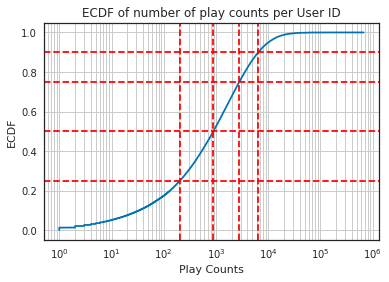

In [13]:
pdf = pd.DataFrame(data=userActivity)
Y=np.sort( pdf[1] )
data_nb = len(Y)
yvals=np.arange(len(Y))/float(data_nb)

print(np.arange(len(Y)))

plt.xscale('log')
plt.plot( Y, yvals )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
for percentile in percentiles:
    plt.axhline(percentile, color='r', linestyle="--")
    plt.axvline(Y[int(data_nb*percentile)], color='r', linestyle='--')
plt.title('ECDF of number of play counts per User ID')
plt.show()

In [14]:
percentile_values = list(zip(percentiles, 
                             [Y[int(data_nb*p)] for p in percentiles]))
pd.DataFrame(percentile_values, 
             columns=["percentiles", "value"])\
  .set_index("percentiles")

,value
percentiles,
0.25,204
0.50,892
0.75,2800
0.90,6484


In [15]:
# used to eliminate outliers (See question 11.2)
user_range = dict(min=Y[int(data_nb*.1)], 
                  max=Y[int(data_nb*.9)])

#### Answer
<div class="alert alert-success">
<p>
The huge majority of users have a limited number of play each (typically, 90% of the users have an individual play count of less than 6500).
</p>
<p>
    As said in the previous question, some users interacts a lot with the systems. Those users will benefit and contribute a lot to the recommendation system. The users that don't contribute much to the system, listening to music, or the new users will have biased recommendations or too generic recommendations:<br>
    An user that have no contribution will have generic prediction based on the whole system as for the "most viewed" homepage in YouTube.<br>
    Some users that contributed too few will have their recommendation based only on their contribution, which can be on the boundaries of what they like, or not focused on the typical listening they want. In that case the recommendation system which is collaborative and therefore based on other users feedback will not associate this user to the right group of users which would give good answers.
</p>
<br>
<p>
    <b>Example:</b> A user with 3 listening, 1 on something he doesn't like (e.g hard-rock) and listened for some random reason, and 2 things he likes (e.g generic, well known classical music) will have biased recommended content as hard-rock remix of classical music, if the users he is associated are listening this knid of music. <br>
    
    This also stresses the importance to have a huge user and listening base to start such a recommendation system.
</p>
<br>
<p>
    Finaly users that listen too much to music are not that interesting because they are likely to let their PC turned on with the music played, even without choosing it, changing automatically with the recommandations given.
</p>
<br>
<p class="alert alert-warning">
    All of these reasons lead to eliminate the "outliers" that are here present and only keep the range [10%-90%]. As a matter of fact we belive that this satifies the central-limit theorem which tells us that a huge number of users will have a gaussian behaviour.
</p>
</div>

#### Question 2.3

<div class="alert alert-info">
How many play counts for each artist? Plot CDF or ECDF of the result.  

Similarly to the previous question, you need to comment and interpret your result: what is the figure telling you?
</div>

In [16]:
# Compute artist popularity
# We are interested in how many playcounts per artist
# ATTENTION! Grouping by artistID may be problematic, as stated above.

artistPopularity = userArtistDF.groupBy("ArtistID").sum("PlayCount").collect()
# Plot the number of Play per artist (for 5 users)
# Pandas allow us to do that in a visual way
pd.DataFrame(artistPopularity[:5], 
             columns=artistPopularity[0].__fields__)\
  .set_index("ArtistID")

,sum(PlayCount)
ArtistID,
1003514,949
1004346,3772
5409,526693
1002519,405
1004223,409


<div class="alert alert-success">
    <p>The PlayCount per artist is a good indicator of the artist popularity. The more the artist is listened the more he is popular.</p>
    <p>The importance of knowing popularity comes from the importance of ratings as it is importance ton know the preferences of a user for collaborative filtering. That's what will be used for gathering 'similar' users according to preferences.</p>
    <p>But there is a problem : very often artist IDs point to song titles as well. This means we have to be careful when establishing popular artists. Indeed, artists whose data is "well formed" will have the correct number of play counts associated to them. Instead, artists that appear mixed with song titles may see their play counts shared across their songs.</p>
</div>

[      0       1       2 ... 1631025 1631026 1631027]


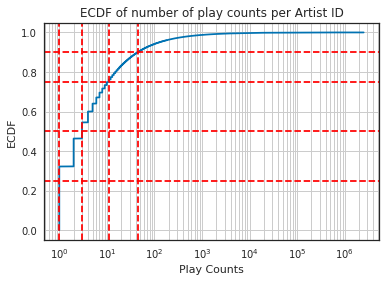

In [17]:
pdf = pd.DataFrame(data=artistPopularity)
Y=np.sort( pdf[1] )
data_nb = len(Y)
yvals=np.arange(data_nb)/float(data_nb)

print(np.arange(data_nb))

plt.xscale('log')
plt.plot( Y, yvals )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
for percentile in percentiles:
    plt.axhline(percentile, color='r', linestyle="--")
    plt.axvline(Y[int(data_nb*percentile)], color='r', linestyle='--')
plt.title('ECDF of number of play counts per Artist ID')
plt.show()

In [18]:
percentile_values = list(zip(percentiles, 
                             [Y[int(data_nb*p)] 
                              for p in percentiles]))

pd.DataFrame(percentile_values, 
             columns=["percentiles", "value"])\
  .set_index("percentiles")

,value
percentiles,
0.25,1
0.50,3
0.75,11
0.90,45


In [19]:
# used to eliminate outliers (See question 11.2)

# The min is set to 50% here as those are 
# artists with less than 4 playcount
# Note than there is here no max: 
# it would be irrelevant to withdraw 
# artists that listened a lot.

artist_range = dict(min=Y[int(data_nb*.4)])

#### Answer
<div class="alert alert-success">
<p>
Same as for the user listenings, only a few artists makes almost all listenings. This can be interpretated with at least two reasons :
    <ul>
        <li>A certain number of artists are mispelled and therefore have a few listening count on the wrong name.</li>
        <li>The artists supported by major labels are most likely to be listened a huge number of times, whereas the number of listening of less known artists is very small. This phenomenon is know as the "long tail" phenomenon: with an amount of artist proposed really big, users tends to listen the artists well known and already listened by a lot of users.</li>
    </ul>
</p>
<p>25% of artists are listened less than 1 time, and the huge majority of them (90%) are only listened less than 45 times, which is extremely small. Most of the artists are not well known, which explains this fact.(Again the long trail phenomenon) </p>
</div>

#### Question 2.4
<div class="alert alert-info">
Plot a bar chart to show top 5 artists In terms of absolute play counts.  

Comment the figure you just obtained: 
<ul>
<li>are these reasonable results?</li>
<li>is looking at top-5 artists enough to learn more about your data?</li>
<li>do you see anything strange in the data?</li>
</ul>
</div>

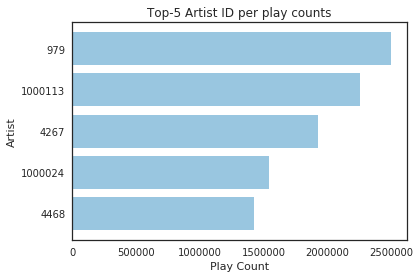

In [20]:
sortedArtist = sorted(artistPopularity, key = lambda x: -x["sum(PlayCount)"])[:5]

artistID = [w["ArtistID"] for w in sortedArtist]

y_pos = range(len(sortedArtist))
frequency = [w[1] for w in sortedArtist]

plt.barh(y_pos, frequency[::-1], align='center', alpha=0.4)
plt.yticks(y_pos, artistID[::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-5 Artist ID per play counts')
plt.show()

<div class="alert alert-success">
<li>The results seem to be reasonable: the play count number can be very big and those numbers and the one we saw previously for the artists less listened corresponds to the long trail phenomenon. </li>
<li>However, looking only at the top 5 is not enough for many reasons. For example, some users may be listening to the same artist many times and this graph won't enable us to figure this out.</li>
<li> And the weird thing here is that only in the top 5 artists, there is a big variation between the first and the fifth (2500000 vs 1400000). We can't know if it's because of the artist IDs that are pointing to songs which dilutes the play count for the fifth artist for example.</li>
</div>

#### Additionnal question
<div class="alert alert-info">
What is the percentage of views made by the top 1% of artists ?
</div>

In [21]:
top1p = Y[int(data_nb*.99)]

print("The top 1% artists makes {:.2f}% of all the listenings."
      .format(np.sum(Y[Y>top1p])*100/np.sum(Y)))

The top 1% artists makes 89.23% of all the listenings.


<div class="alert alert-success">
<p>
    This verifies the previous remarks on the <i>long-tail</i> phenomenon.
</p>
</div>

All seems clear right now, but ... wait a second! What about the problems indicated above about artist "disambiguation"? Are these artist ID we are using referring to unique artists? How can we make sure that such "opaque" identifiers point to different bands? Let's try to use some additional dataset to answer this question:  `artist_data.txt` dataset. This time, the schema of the dataset consists in:

```
artist ID: long int
name: string
```

We will try to find whether a single artist has two different IDs.

### Question 3

#### Question 3.1

<div class="alert alert-info">
Load the data from `/datasets/lastfm/artist_data.txt` and use the SparkSQL API to show 5 samples.  

<ul></ul>
<div class="label label-success">HINT:</div> If you encounter some error when parsing lines in data because of invalid entries, parameter `mode='DROPMALFORMED'` will help you to eliminate these entries. The suggested syntax is: `<df>.options(header='false', delimiter='\t', mode='DROPMALFORMED')`.

</div>

In [22]:
customSchemaArtist = StructType([ \
    StructField("artistID", LongType(), True), \
    StructField("name", StringType(), True)])

artistDF = (
            sqlContext.read 
                .format('com.databricks.spark.csv') 
                # Drop the invalid entries
                .options(header='false', delimiter='\t', mode='DROPMALFORMED')
                # The schema is the one above
                .load(base + "artist_data.txt", schema = customSchemaArtist)
            )

# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
artistDF.cache()

# Ensure the data are correctly loaded
artistDF.show(5)

+--------+--------------------+
|artistID|                name|
+--------+--------------------+
| 1134999|        06Crazy Life|
| 6821360|        Pang Nakarin|
|10113088|Terfel, Bartoli- ...|
|10151459| The Flaming Sidebur|
| 6826647|   Bodenstandig 3000|
+--------+--------------------+
only showing top 5 rows



#### Question 3.2
<div class="alert alert-info">
Find 20 artists whose name contains `Aerosmith`. Take a look at artists that have ID equal to `1000010` and `2082323`. In your opinion, are they pointing to the same artist?  

<ul></ul>
<div class="label label-success">HINT:</div> Function `locate(sub_string, string)` can be useful in this case.
</div>

In [23]:
# get artists whose name contains "Aerosmith"
artistDF[locate("Aerosmith", "name") > 0].show(20)

# show two examples
artistDF[artistDF.artistID==1000010].show()
artistDF[artistDF.artistID==2082323].show()

+--------+--------------------+
|artistID|                name|
+--------+--------------------+
|10586006|Dusty Springfield...|
| 6946007|    Aerosmith/RunDMC|
|10475683|Aerosmith: Just P...|
| 1083031|    Aerosmith/ G n R|
| 6872848|Britney, Nsync, N...|
|10586963|Green Day - Oasis...|
|10028830|The Aerosmith Ant...|
|10300357| Run-DMC + Aerosmith|
| 2027746|Aerosmith by Musi...|
| 1140418|[rap]Run DMC and ...|
|10237208| Aerosmith + Run DMC|
|10588537|Aerosmith, Kid Ro...|
| 9934757|Aerosmith - Big Ones|
|10437510|Green Day ft. Oas...|
| 6936680| RUN DNC & Aerosmith|
|10479781|      Aerosmith Hits|
|10114147|Charlies Angels -...|
| 1262439|Kid Rock, Run DMC...|
| 7032554|Aerosmith & Run-D...|
|10033592|          Aerosmith?|
+--------+--------------------+
only showing top 20 rows

+--------+---------+
|artistID|     name|
+--------+---------+
| 1000010|Aerosmith|
+--------+---------+

+--------+------------+
|artistID|        name|
+--------+------------+
| 2082323|01 Aerosmith|
+---

#### Answer
<div class="alert alert-success">
<p>
    Many artists names contains <cite>Aerosmith</cite>, among them, there are duplicates for this music group (and surely for other artists). We can see that the name of the artist is accompanied with a song name and others or just mispelled. We then have to remove duplicates by adressing them to the right artist.
</p>
</div>

To answer this question correctly, we need to use an additional dataset `artist_alias.txt` which contains the ids of mispelled artists and standard artists. The schema of the dataset consists in:

```
mispelledID ID: long int
standard ID: long int
```

#### Question 3.3
<div class="alert alert-info">
Using SparkSQL API, load the dataset from `/datasets/lastfm/artist_alias.txt` then show 5 samples.
</div>

In [24]:
customSchemaArtistAlias = StructType([ \
    StructField( "MispelledArtistID", LongType(), True ), \
    StructField( "StandardArtistID", LongType(), True )])

# We have to drop NA values, as is doesn't provide reliable information.

artistAliasDF = (
                sqlContext.read \
                    .format('com.databricks.spark.csv') 
                    .options(header='false', delimiter='\t', mode='DROPMALFORMED') 
                    .load(base + "artist_alias.txt", schema = customSchemaArtistAlias)
                    # Drop the invalid entries: some entries does not have both a key and a value
                    .dropna() 
                )
    
# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
artistAliasDF.cache()

# Ensure the data are correctly loaded
artistAliasDF.show(5)

+-----------------+----------------+
|MispelledArtistID|StandardArtistID|
+-----------------+----------------+
|          1092764|         1000311|
|          1095122|         1000557|
|          6708070|         1007267|
|         10088054|         1042317|
|          1195917|         1042317|
+-----------------+----------------+
only showing top 5 rows



#### Question 3.4
<div class="alert alert-info">
Verify the answer of question 3.2 ("Are artists that have ID equal to `1000010` and `2082323` the same ?") by finding the standard ids corresponding to the mispelled ids `1000010` and `2082323` respectively.
</div>

In [25]:
artistAliasDF[ artistAliasDF["MispelledArtistID"] == 1000010 ].show()
artistAliasDF[ artistAliasDF["MispelledArtistID"] == 2082323 ].show()

# 1000010 is a standard id, so it haven't been considered as mispelled id in the dataset

+-----------------+----------------+
|MispelledArtistID|StandardArtistID|
+-----------------+----------------+
+-----------------+----------------+

+-----------------+----------------+
|MispelledArtistID|StandardArtistID|
+-----------------+----------------+
|          2082323|         1000010|
+-----------------+----------------+



#### Answer
<div class="alert alert-success">
<p>
    Real artists don't have any entry in the aliases dataset.
</p>
    It confirms that '01 Aerosmith' and 'Aerosmith' correspond to the same artist.
</div>

### Question 4

The mispelled or nonstandard information about artist make our results in the previous queries a bit "sloppy". To overcome this problem, we can replace all mispelled artist ids by the corresponding standard ids and re-compute the basic descriptive statistics on the "amended" data.
First, we construct a "dictionary" that maps non-standard ids to a standard ones. Then this "dictionary" will be used to replace the mispelled artists.

#### Question 4.1
<div class="alert alert-info">
From data in the dataframe loaded from `/datasets/lastfm/artist_alias.txt`, construct a dictionary that maps each non-standard id to its standard id.  

<div class="label label-success">HINT:</div> Instead of using function `collect`, we can use `collectAsMap` to convert the collected data to a dictionary inline.
</div>

In [26]:
artistAlias = (artistAliasDF
                .rdd
                .map(lambda row: ( row["MispelledArtistID"], 
                                   row["StandardArtistID"]))
                .collectAsMap())

#### Answer
<div class="alert alert-success">
<p>
    We can store the aliases with a key-value pair data structure: this is pretty optimized for the current situation as we won't read all the values linearly. Then the reading of a value with the <q>MispelledArtistID</q> key will be in O(1). As far as we will access all the keys in a random order this will save a lot of time and computing power.
    <br>
    Furthermore, the transformation to a disctionnary is distributedly made and takes advantage of the four workers.
</p>
</div>

#### Question 4.2
<div class="alert alert-info">
Using the constructed dictionary in question 4.1, replace the non-standard artist ids in the dataframe that was loaded from `/datasets/lastfm/user_artist_data.txt` by the corresponding standard ids then show 5 samples.
</div>


**NOTE 1**: If an id doesn't exist in the dictionary as a mispelled id, it is really a standard id.


Using funtion `map` on Spark Dataframe will give us an RDD. We can convert this RDD back to Dataframe by using `sqlContext.createDataFrame(rdd_name, sql_schema)`


**NOTE 2**: be careful! you need to be able to verify that you indeed solved the problem of having bad artist IDs. In principle, for the new data to be correct, we should to have duplicate pairs (user, artist), potentially with different play counts, right? In answering the question, please **show** that you indeed fixed the problem. 

In [27]:
loops_number = 20

for _ in range(loops_number):
    for k, v in artistAlias.items():
        artistAlias[k] = artistAlias.get(v, v)
        
print("The number of artist aliases is {}."
      .format(len(artistAlias.values())))
print("The number of attractors in the artist aliases is {}."
      .format(len(set(artistAlias.values()))))                                         


The number of artist aliases is 190892.
The number of attractors in the artist aliases is 22444.


#### Answer
<div class="alert alert-success">
<p>
    The loop ensures that the chained aliases will also be processed. However this is not a satisfying solution as the map function is computationnaly heavy. We will see later (part 4) in this notebook a better solution that uses DAGs to deal with that issue.
</p>
</div>

In [28]:
from time import time

def replaceMispelledIDs(fields):
    # dict.get(a,b) returns dict[a] if found, else b
    # Here it returns the original artist ID if mispelled, 
    # and if this is the orginal artist ID, it keeps it.
    finalID = artistAlias.get(fields[1], fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()
newUserArtistDF = sqlContext.createDataFrame(
    # Takes advantage of the 4 workers
    userArtistDF.rdd.map(replaceMispelledIDs),
    userArtistDataSchema
)
newUserArtistDF.show(5)

t1 = time()

print("The script takes {:.3f} seconds".format(t1-t0))

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
+-------+--------+---------+
only showing top 5 rows

The script takes 1.611 seconds


In [29]:
# Check that we solved the problem

t0 = time()

(newUserArtistDF
     # We don't want duplicates with the same number of playCount for each key
     .groupby("userID", "artistID")
     # Then we compute the number of entries for each key
     .count()
     # Finaly we display only the keys for which the keys have been duplicated
     .filter("count(playcount) >= 2")
     .show(5))

t1 = time()

print("The script takes {:.3f} seconds".format(t1-t0))

+-------+--------+-----+
| userID|artistID|count|
+-------+--------+-----+
|2287002| 1018768|    4|
|2287049| 1005039|    2|
|2287764| 1052332|    2|
|2288269| 1008824|    2|
|2288457| 2003588|    2|
+-------+--------+-----+
only showing top 5 rows

The script takes 84.416 seconds


#### Answer
<div class="alert alert-success">
<p>
    Some entries are duplicated with a different playCount, which is an evidence that mispelled artists now have the right artistID.
</p>
<p>
    This cell takes some time to compute as the data need to be reshuffled (the key sorting changes, and the network is indeed a bottleneck)
</p>
</div>

#### Question 4.3
<div class="alert alert-info">
Spark actions are executed through a set of stages, separated by distributed "shuffle" operations. Spark can be instructed to **automatically and efficiently** broadcast common data needed by tasks within **each stage**. The data broadcasted this way is cached in **serialized form** and deserialized before running each task.   
<ul> </ul>
We can thus improve our answer to question 4.2: we can reduce the communication cost by shipping the "dictionary" in a more efficient way by using `broadcast variable`. Broadcast variables allow the programmer to keep a read-only variable cached on **each machine** rather than shipping a copy of it with tasks. They are cached in deserialized form. They can be used, for example, to give every node a copy of a large input dataset in an efficient manner.   
<ul></ul>
The broadcast of variable `v` can be created by `bV = sc.broadcast(v)`. Then value of this broadcast variable can be access via `bV.value`  

<ul></ul>
To question is then: using a broadcast variable, modify the script in question 4.2 to get better performance in terms of running time.
</div>


In [30]:
from time import time

bArtistAlias = sc.broadcast(artistAlias)

def replaceMispelledIDs(fields):
    finalID = bArtistAlias.value.get(fields[1], fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
                    userArtistDF.rdd.map(replaceMispelledIDs), 
                    userArtistDataSchema
                  )
print(newUserArtistDF.show(5))
t1 = time()

print("The script takes {:.3f} seconds".format(t1-t0))

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
+-------+--------+---------+
only showing top 5 rows

None
The script takes 0.254 seconds


#### Answer
<div class="alert alert-success">
<p>
Broadcasting variables is way faster than accessing it each time from the driver. The network is a huge bottleneck in the previous implementation.
</p>
</div>

Although having some advantages, explicitly creating broadcast variables is only useful when tasks across multiple stages need the same data or when caching the data in deserialized form is important.

### Question 5

Well, our data frame contains clean and "standard" data. We can use it to redo previous statistic queries.

#### Question 5.1
<div class="alert alert-info">
How many unique artists? Compare with the result when using old data.
</div>

In [39]:
# Previous unique artists number (without correcting aliases)
mispelledUniqueArtists = uniqueArtists

# Computing the new count
uniqueArtists = newUserArtistDF.select("artistID").distinct().count()

print("Total n. of artists: ", uniqueArtists)

Total n. of artists:  1568117


In [40]:
print("There was {} non correct artist entries!"
          .format(mispelledUniqueArtists - uniqueArtists)
      + "\n" +
      "({:.2f} % of the artist entries)"
          .format(100*(mispelledUniqueArtists - uniqueArtists)/mispelledUniqueArtists))

There was 62911 non correct artist entries!
(3.86 % of the artist entries)


#### Answer
<div class="alert alert-success">
<p>
The number of artists decreases once the mispelling is corrected. This will lead to better results in recommendation due to a less sparse matrix and correct number of listening in it.
</p>
</div>

#### Question 5.2

<div class="alert alert-info">
Who are the top-10 artists?
<ul>
  <li>In terms of absolute play counts</li>
  <li>In terms of "audience size", that is, how many users listened to one of their track at least once</li>
</ul>  

Plot the results, and explain the figures you obtain.
</div>

In [ ]:
# calculate top-10 artists in term of play counts
top10ArtistsPC = (
                    newUserArtistDF
                        .groupBy( "artistID" )
                        .sum( "playCount" )
                        .orderBy('sum(playCount)', ascending=0)
                        .take(10)
                  )

y_pos = range(len(top10ArtistsPC))
pdf = pd.DataFrame(data=top10ArtistsPC)

top10PC_set = set(pdf[0])

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per play counts')
plt.show()

In [ ]:
# calculate top-10 artists in term of audience size
top10ArtistsASS = (
                    newUserArtistDF
                        .select(["userID", "artistID"])
                        .drop_duplicates()
                        .groupBy( "artistID" )
                        .count()
                        .orderBy('count', ascending=0)
                        .take(10)
                  )

y_pos = range(len(top10ArtistsASS))
pdf = pd.DataFrame(data=top10ArtistsASS)

top10ASS_set = set(pdf[0])

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Audience size')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per audience size')
plt.show()

In [ ]:
# Artists that are in both top10 

top10PC_set & top10ASS_set

#### Answer
<div class="alert alert-success">
<p>
5 Artists are in both of the top ten ranking. Those artists benefits from a large audience which increases their playCount. The other artists in the top 10 for playCounts are more likely to be loop-listened.
</p>
</div>

#### Question 5.3

<div class="alert alert-info">
Who are the top-10 users?
<ul>
  <li>In terms of absolute play counts</li>
  <li>In terms of "curiosity", that is, how many different artists they listened to</li>

</ul>  

Plot the results
</div>

In [ ]:
# calculate top 10 users interm of play counts
top10UsersByPlayCount = (
                        newUserArtistDF
                             .groupBy( "userID" )
                             .sum( "playCount" )
                             .orderBy('sum(playCount)', ascending=0)
                             .take(10)
                        )

y_pos = range(len(top10UsersByPlayCount))
pdf = pd.DataFrame(data=top10UsersByPlayCount)

top10PC_set = set(pdf[0])

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Play Count')
plt.ylabel('User')
plt.title('Top-10 Users ID per play counts')
plt.show()

<div class="alert alert-success">
<p>
    These users are likely to play music the whole day (and night) without beeing its time all the time. These may be professionnals (ambiance listening) or users that forgot their music playing pretty often.
</p>
</div>

In [ ]:
# calculate top 10 users interm of curiosity
top10UsersByCuriosity = (
                        newUserArtistDF
                            .groupBy("userID")
                            .count()
                            .orderBy('count', ascending=0)
                            .take(10)
                        )

y_pos = range(len(top10UsersByCuriosity))
pdf = pd.DataFrame(data=top10UsersByCuriosity)

top10cur_set = set(pdf[0])

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Different artists count')
plt.ylabel('User')
plt.title('Top-10 Users ID per curiosity')
plt.show()

In [ ]:
# Users that are in both top10 

top10PC_set & top10cur_set

#### Answer
<div class="alert alert-success">
<p>
    No user is in the curiosity top 10 and the play count top 10, which seems legit if we consider the play count top 10 as not very concentrated on their musical choices (which is obviously the case, with regard to their play count).
</p>
</div>

Now we have some valuable information about the data. It's the time to study how to build a statistical models.

# 2. Build a statistical models to make recommendations

## 2.1 Introduction to recommender systems

In a recommendation-system application there are two classes of entities, which we shall refer to as `users` and `items`. Users have preferences for certain items, and these preferences must be inferred from the data. The data itself is represented as a `preference matrix` $A$, giving for each user-item pair, a value that represents what is known about the degree of preference of that user for that item. The table below is an example for a `preference matrix` of 5 users and `k` items. The `preference matrix` is also known as `utility matrix`.

| | IT1 | IT2 | IT3 | ... | ITk |
|---|---|---|---|---|---|
| U1 | 1 |  | 5 | ... | 3 |
| U2 |  | 2 |  | ... | 2 |
| U3 | 5 |  | 3 | ... |  |
| U4 | 3 | 3 |  | ... | 4 |
| U5 |  | 1 |  | ... | ... |

The value of row i, column j expresses how much does user `i` like item `j`. The values are often the rating scores of users for items. An unknown value implies that we have no explicit information about the user's preference for the item. The goal of a recommendation system is to predict "the blanks" in the `preference matrix`. For example, assume that the rating score is from 1 (dislike) to 5 (love), would user `U5` like `IT3` ? We have two approaches:

* Designing our recommendation system to take into account properties of items such as brand, category, price... or even the similarity of their names. We can denote the similarity of items `IT2` and `IT3`, and then conclude that because user `U5` did not like `IT2`, they were unlikely to enjoy SW2 either.

* We might observe that the people who rated both `IT2` and `IT3` tended to give them similar ratings. Thus, we could conclude that user `U5` would also give `IT3` a low rating, similar to `U5`'s rating of `IT2`

It is not necessary to predict every blank entry in a `utility matrix`. Rather, it is only necessary to discover some entries in each row that are likely to be high. In most applications, the recommendation system does not oﬀer users a ranking of all items, but rather suggests a few that the user should value highly. It may not even be necessary to ﬁnd all items with the highest expected ratings, but only to ﬁnd a large subset of those with the highest ratings.


## 2.2 Families of recommender systems

In general, recommender systems can be categorized into two groups:

* **Content-Based** systems focus on properties of items. Similarity of items is determined by measuring the similarity in their properties.

* **Collaborative-Filtering** systems focus on the relationship between users and items. Similarity of items is determined by the similarity of the ratings of those items by the users who have rated both items.

In the usecase of this notebook, artists take the role of `items`, and `users` keep the same role as `users`.
Since we have no information about `artists`, except their names, we cannot build a `content-based` recommender system.

Therefore, in the rest of this notebook, we only focus on `Collaborative-Filtering` algorithms.

## 2.3 Collaborative-Filtering 
In this section, we study a member of a broad class of algorithms called `latent-factor` models. They try to explain observed interactions between large numbers of users and products through a relatively small number of unobserved, underlying reasons. It is analogous to explaining why millions of people buy a particular few of thousands of possible albums by describing users and albums in terms of tastes for perhaps tens of genres, tastes which are **not directly observable or given** as data. 

First, we formulate the learning problem as a matrix completion problem. Then, we will use a type of `matrix factorization` model to "fill in" the blanks.  We are given implicit ratings that users have given certain items (that is, the number of times they played a particular artist) and our goal is to predict their ratings for the rest of the items. Formally, if there are $n$ users and $m$ items, we are given an $n \times m$ matrix $R$ in which the generic entry $(u, i)$ represents the rating for item $i$ by user $u$. **Matrix $R$ has many missing entries indicating unobserved ratings, and our task is to estimate these unobserved ratings**.

A popular approach to the matrix completion problem is **matrix factorization**, where we want to "summarize" users and items with their **latent factors**.

### 2.3.1 Basic idea and an example of Matrix Factorization
For example, given a preference matrix 5x5 as below, we want to approximate this matrix into the product of two smaller matrixes $X$ and $Y$ .

$$
M = 
\begin{bmatrix}
 5 & 2 & 4 & 4 & 3 \\
 3 & 1 & 2 & 4 & 1 \\
 2 &  & 3 & 1 & 4 \\
 2 & 5 & 4 & 3 & 5 \\
 4 & 4 & 5 & 4 &  \\
\end{bmatrix}
\approx M^\prime =
\begin{bmatrix}
 x_{11} & x_{12} \\
 x_{21} & x_{22} \\
 x_{31} & x_{32} \\
 x_{41} & x_{42} \\
 x_{51} & x_{52} \\
\end{bmatrix}
\times
\begin{bmatrix}
 y_{11} & y_{12} & y_{13} & y_{14} & y_{15} \\
 y_{21} & y_{22} & y_{23} & y_{24} & y_{25} \\
\end{bmatrix}
$$

$M^\prime$ is an approximation that is as close to A as possible. To calculate how far from $M$ $M^\prime$ is, we often calculate the sum of squared distances of non-empty elements in $M$ and the corresponding elements in $M^\prime$.
In this way, for $M^\prime$, besides the approximated elements in $M$, we also have the non-observed elements. Therefore, to see how much does user `i` like item `j`, we simply pick up the value of $M^\prime_{i,j}$.

The challenge is how to calculate $X$ and $Y$. The bad news is that this can't be solved directly for both the best $X$ and best $Y$ at the same time. Fortunately, if $Y$ is known, we can calculate the best of $X$, and vice versa. It means from the initial values of $X$ and $Y$ in the beginning, we calculate the best $X$ according to $Y$, and then calculate the best $Y$ according to the new $X$. This process is repeated until the distance from $XY$ to $M$ is small. It's simple, right ?

Let's take an example. To compute the approximation for the above 5x5 matrix $M$, first, we initialize the value of $X$ and $Y$ as below.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

With the initial iteration, we calculate the the Root-Mean-Square Error from $XY$ to $M$.

Consider the ﬁrst rows of $M$ and $XY$ . We subtract the first row of $XY$ from the entries in the ﬁrst row of $M$, to get $3,0,2,2,1$. We square and sum these to get $18$. 

In the second row, we do the same to get $1,−1,0,2,−1$, square and sum to get $7$. 

In the third row, the second column is blank, so that entry is ignored when computing the RMSE. The diﬀerences are $0,1,−1,2$ and the sum of squares is $6$. 

For the fourth row, the diﬀerences are $0,3,2,1,3$ and the sum of squares is $23$. 

The ﬁfth row has a blank entry in the last column, so the diﬀerences are $2,2,3,2$ and the sum of squares is $21$. 

When we sum the sums from each of the ﬁve rows, we get $18+7+6+23+21 = 75$. So, $RMSE=\sqrt{75/23}=1.806$ where $23$ is the number of non-empty values in $M$.

Next, with the given value of $Y$, we calculate $X$ by finding the best value for $X_{11}$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 x & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 x+1 & x+1 & x+1 & x+1 & x+1 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

Now, to minimize the $RMSE$  we minimize the difference of the first rows $(5−(x+1))^2 + (2−(x+1))^2 + (4−(x+1))^2 + (4−(x+1))^2 + (3−(x+1))^2$. By  taking the derivative and set that equal to 0, we pick $x=2.6$

Given the new value of $X$, we can calculate the best value for $Y$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 2.6 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 y & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 3.6 & 3.6 & 3.6 & 3.6 & 3.6 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

By doing the same process as before, we can pick value for $y=1.617$. After that, we can check if the $RMSE$ is not converged, we continue to update $X$ by $Y$ and vice versa. In this example, for simple, we only update one element of each matrix in each iteration. In practice, we can update a full row or full matrix at once.


### 2.3.2 Matrix Factorization: Objective and ALS Algorithm on a Single Machine

More formally, in general, we select $k$ latent features, and describe each user $u$ with a $k-$dimensional vector $x_u$, and each item $i$ with a $k-$dimensional vector $y_i$.

Then, to predict user $u$'s rating for item $i$, we do as follows: $ r_{ui} \approx x_{u}^{T}y_i$.

This can be put, more elegantly, in a matrix form. Let $x_1, \cdots x_n \in \mathbb{R}^k$ be the factors for the users, and $y_1, \cdots y_m \in \mathbb{R}^k$ the factors for the items. The $k \times n$ user matrix $X$ and the $k \times m$ item matrix $Y$ are then defined by:

$$
X = 
\begin{bmatrix}
 |   &         & |  \\
x_1  &  \cdots & x_n\\
 |   &         & |  \\
\end{bmatrix}
$$

$$
Y = 
\begin{bmatrix}
 |   &         & |  \\
y_1  &  \cdots & y_i\\
 |   &         & |  \\
\end{bmatrix}
$$

Our goal is to estimate the complete ratings matrix $R \approx X^{T} Y$. We can formulate this problem as an optimization problem in which we aim to minimize an objective function and find optimal $X$ and $Y$ . In particular, we aim to minimize the least squares error of the observed ratings (and regularize):

$$
\min_{X,Y} \sum_{r_{ui} \text{observed}}(r_{ui} - x_{u}^{T}y_i)^2 + \lambda \left( \sum_{u} \|x_u\|^2 + \sum_{i} \|y_i\|^2 \right) 
$$

Notice that this objective is non-convex (because of the $x_{u}^{T} y_i$ term); in fact it’s NP-hard to optimize. Gradient descent can be used as an approximate approach here, however it turns out to be slow and costs lots of iterations. Note however, that if we fix the set of variables $X$ and treat them as constants, then the objective is a convex function of $Y$ and vice versa. Our approach will therefore be to fix $Y$ and optimize $X$, then fix $X$ and optimize $Y$, and repeat until convergence. This approach is known as **ALS (Alternating Least Squares)**. For our objective function, the alternating least squares algorithm can be expressed with this simple pseudo-code:


**Initialize** $X$, $Y$

**while(convergence is not true) do**


**for** $u = 1 \cdots n$ **do**

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 
   
**end for**

**for** $u = 1 \cdots n$ **do**

$y_i = \left( \sum_{r_ui \in r_{*i}} x_u x_{u}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{*i}} r_{ui} x_u $ 
   
**end for**


**end while**


For a single machine, we can analyze the computational cost of this algorithm. Updating each $x_u$ will cost $O(n_u k^2 + k^3)$, where $n_u$ is the number of items rated by user $u$, and similarly updating each $y_i$ will cost $O(n_i k^2 + k^3)$, where $n_i$ is the number of users that have rated item $i$.


Once we’ve computed the matrices $X$ and $Y$, there are several ways compute a prediction. The first is to do what was discussed before, which is to simply predict $ r_{ui} \approx x_{u}^{T}y_i$ for each user $u$ and item $i$. 
This approach will cost $O(nmk)$ if we’d like to estimate every user-item pair. 

However, this approach is prohibitively expensive for most real-world datasets. A second (and more holistic) approach is to use the $x_u$ and $y_i$ as features in another learning algorithm, incorporating these features with others that are relevant to the prediction task.

### 2.3.3 Parallel Altenating Least Squares

There are several ways to distribute the computation of the ALS algorithm depending on how data is partitioned.

#### Method 1: using joins
First we consider a fully distributed version, in the sense that all data (both input and output) is stored in a distributed file system. In practice, input data (ratings) and parameters ($X$ and $Y$) are stored in an a Spark RDD. Specifically, ratings -- that are always **sparse** -- are stored as RDD of triplets:

Ratings: RDD((u, i, $r_{ui}$), . . . )


Instead, we can use dense representation for factor matrices $X$ and $Y$, and these are stored as RDDs of vectors. More precisely, we can use the data types introduced in Spark MLLib to store such vectors and matrices:

X : RDD($x_1$,...,$x_n$)

Y : RDD($y_1$,...,$y_m$)


Now, recall the expression to compute $x_u$:

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 

Let's call the first summation *part A* and the second summation *part B*. To compute such parts, in parallel, we can proceed with the following high-level pseudocode:

* Join the Ratings RDD with the $Y$ matrix RDD using key $i$ (items)
* Map to compute $y_i y_{i}^{T}$ and emit using key $u$ (user)
* ReduceByKey $u$ (user) to compute $\sum_{r_ui \in r_{u*}} y_i y_{i}^{T}$
* Invert
* Another ReduceByKey $u$ (user) to compute $\sum_{r_ui \in r_{u*}} r_{ui} y_i$

We can use the same template to copmute $y_i$.

This approach works fine, but note it requires computing $y_i y_{i}^{T}$ for each user that has rated item $i$. 

#### Method 2: using broadcast variables (advanced topic)
The next approach takes advantage of the fact that the $X$ and $Y$ factor matrices are often very small and can be stored locally on each machine.

* Partition the Ratings RDD **by user** to create $R_1$, and similarly partition the Ratings RDD **by item** to create $R_2$. This means there are two copies of the same Ratings RDD, albeit with different partitionings. In $R_1$, all ratings by the same user are on the same machine, and in $R_2$ all ratings for same item are on the same machine.
* Broadcast the matrices $X$ and $Y$. Note that these matrices are not RDD of vectors: they are now "local: matrices.
* Using $R_1$ and $Y$, we can use expression $x_u$ from above to compute the update of $x_u$ locally on each machine
* Using $R_2$ and $X$, we can use expression $y_i$ from above to compute the update of $y_i$ locally on each machine

A further optimization to this method is to group the $X$ and $Y$ factors matrices into blocks (user blocks and item blocks) and reduce the communication by only sending to each machine the block of users (or items) that are needed to compute the updates at that machine. 

This method is called **Block ALS**. It is achieved by precomputing some information about the ratings matrix to determine the "out-links" of each user (which blocks of the items it will contribute to) and "in-link" information for each item (which of the factor vectors it receives from each user block it will depend on). For exmple, assume that machine 1 is responsible for users 1,2,...,37: these will be block 1 of users. The items rated by these users are block 1 of items. Only the factors of block 1 of users and block 1 of items will be broadcasted to machine 1.

### Further readings
Other methods for matrix factorization include:

* Low Rank Approximation and Regression in Input Sparsity Time, by Kenneth L. Clarkson, David P. Woodruff. http://arxiv.org/abs/1207.6365
* Generalized Low Rank Models (GLRM), by Madeleine Udell, Corinne Horn, Reza Zadeh, Stephen Boyd. http://arxiv.org/abs/1410.0342
* Matrix Completion and Low-Rank SVD via Fast Alternating Least Squares, by Trevor Hastie, Rahul Mazumder, Jason D. Lee, Reza Zadeh . Statistics Department and ICME, Stanford University, 2014. http://stanford.edu/~rezab/papers/fastals.pdf

# 3. Usecase : Music recommender system

In this usecase, we use the data of users and artists in the previous sections to build a statistical model to recommend artists for users.
 
## 3.1 Requirements
According to the properties of data, we need to choose a recommender algorithm that is suitable for this implicit feedback data. It means that the algorithm should learn without access to user or artist attributes such as age, genre,.... Therefore, an algorithm of type `collaborative filtering` is the best choice.

Second, in the data, there are some users that have listened to only 1 artist. We need an algorithm that might provide decent recommendations to even these users. After all, at some point, every user starts out with just one play at some point! 

Third, we need an algorithm that scales, both in its ability to build large models, and to create recommendations quickly. So, an algorithm which can run on a distributed system (SPARK, Hadoop...) is very suitable.

From these requirement, we can choose using ALS algorithm in SPARK's MLLIB.

Spark MLlib’s ALS implementation draws on ideas from [1](http://yifanhu.net/PUB/cf.pdf) and [2](http://link.springer.com/chapter/10.1007%2F978-3-540-68880-8_32).

## 3.2 Notes

Currently, MLLIB can only build models from an RDD. That means we have two ways to prepare data:

* Loading to into SPARK SQL DataFrame as before, and then access the corresponding RDD by calling `<dataframe>.rdd`. The invalid data is often sucessfully dropped by using mode `DROPMALFORMED`. However, this way might not work in all cases. Fortunately, we can use it with this usecase.

* Loading data directly to RDD. However, we have to deal with the invalid data ourself. In the trade-off, this way is the most reliable, and can work in every case.

In this notebook, we will use the second approach: it requires a bit more effort, but the reward is worth it!

 
## 3.3 Cleanup the data
In section 1, we already replaced the ids of mispelled artists by the corresponding standard ids by using SPARK SQL API.
However, if the data has the invalid entries such that SPARK SQL API is stuck, the best way to work with it is using an RDD.

Just as a recall, we work with three datasets in `user_artist_data.txt`, `` and `artist_alias.txt`. The entries in these file can be empty or have only one field. 

In details our goal now is:

* Read the input ```user_artist_data.txt``` and transforms its representation into an output dataset.
* To produce an output "tuple" containing the original user identifier and play counts, but with the artist identifier replaced by its most common alias, as found in the ```artist_alias.txt``` dataset.
* Since the ```artist_alias.txt``` file is small, we can use a technique called **broadcast variables** to make such transformation more efficient.


### Question 6

#### Question 6.1

<div class="alert alert-info">
Load data from `/datasets/lastfm/artist_alias.txt` and filter out the invalid entries to construct a dictionary to map from mispelled artists' ids to standard ids.
</div>

NOTE: From now on, we will use the "standard" data to train our model.

HINT: If a line contains less than 2 fields or contains invalid numerial values, we can return a special tuple. After that, we can filter out these special tuples.

In [ ]:
rawArtistAlias = sc.textFile(base + "artist_alias.txt")

def xtractFields(s):
    # Using white space or tab character as separators,
    # split a line into list of strings 
    line = re.split("\s|\t",s,1)
    # if this line has at least 2 characters
    if (len(line) > 1):
        try:
            # try to parse the first and the second components to integer type
            return (int(line[0]), int(line[1]))
        except ValueError:
            # if parsing has any error, return a special tuple
            return (-1,-1)
    else:
        # if this line has less than 2 characters, return a special tuple
        return (-1,-1)

artistAlias = (
                rawArtistAlias
                    # extract fields using function xtractFields
                    .map( xtractFields )
    
                    # filter out the special tuples
                    .filter( lambda x:x!=(-1,-1) )
    
                    # collect result to the driver as a "dictionary"
                    .collectAsMap()
                )

# Preventing alias-chains
for _ in range(loops_number):
    for k, v in artistAlias.items():
        artistAlias[k] = artistAlias.get(v, v)

#### Question 6.2
<div class="alert alert-info">
Using the dictionary in question 6.1, prepare RDD `userArtistDataRDD` by replacing mispelled artists' ids to standard ids. Show 5 samples.
</div>

HINT: Using broadcast varible can help us increase the effiency.

In [ ]:
bArtistAlias = sc.broadcast(artistAlias)
rawUserArtistData = sc.textFile(base + "user_artist_data.txt")

def disambiguate(line):
    [userID, artistID, count] = line.split(' ')
    finalArtistID = bArtistAlias.value.get(artistID, artistID)
    return (userID, finalArtistID, count)

userArtistDataRDD = rawUserArtistData.map(disambiguate)
userArtistDataRDD.take(5)

In [ ]:
# TODO
# Use the previously cleaned data 

cleanUserArtistDF.rdd.collect(5)

## 3.4 Training our statistical model
To train a model using ALS, we must use a preference matrix  as an input. MLLIB uses the class `Rating` to support the construction of a distributed preference matrix.

### Question 7

#### Question 7.1
<div class="alert alert-info">
Given RDD `userArtistDataRDD` in question 6.2, construct a new RDD `trainingData` by tranforming each item of it into a `Rating` object.
</div>

In [ ]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

In [ ]:
# after replacing mispelled artist ids, the data contains some play count duplications of a user with the same artist
# remember to aggregate these records

t0 = time()

allData = (
            userArtistDataRDD
                # Map-Reduce implementation to remove play count duplications
                # Transforms data to key-value pairs (key=(UserID, ArtistID) , value=playCount)
                .map(lambda x: ((x[0], x[1]),x[2]))
                # Aggregates the duplicated playCount by summing them
                .reduceByKey(sum)
                # Use the right datastructure for recommendation algorithms, 
                # which is the Rating object in Spark
                .map(lambda r: Rating(r[0][0], r[0][1], r[1]))
                # Set the repartition to 4 datanodes to split the data into our 4 workers
                .repartition(numPartitions=4)
                # Cache the dataset
                .cache()
            )
             
print("\n".join(map(repr,allData.take(5))))

t1 = time()

print("The script takes {:.3f} seconds".format(t1-t0))

#### Answer
<div class="alert alert-success">
<p>
    There are 4 workers, therefore the repartition number is set to 4 which means that each worker is supposed to have an equal workload while processing the data (reparted equally between them).
</p>
<p>
    Here, the main bottleneck is the <code>reduceByKey</code> function which takes about 3/4 of the overall running time. This is partly due to the huge number of keys here.
</p>

</div>

#### Question 7.2
<div class="alert alert-info">
A model can be trained by using `ALS.trainImplicit(<training data>, <rank>)`, where:
<ul>
<li>`training data` is the input data you decide to feed to the ALS algorithm</li>
<li>`rank` is the number of laten features</li>
</ul>  


We can also use some additional parameters to adjust the quality of the model. Currently, let's set 
<ul>
<li>`rank=10`</li>
<li>`iterations=5`</li>
<li>`lambda_=0.01`</li>
<li>`alpha=1.0` </li>
</ul>
to build model.
</div>

In [ ]:
t0 = time()
model = ALS.trainImplicit(allData,
                            rank=10,
                            iterations=5,
                            lambda_=0.01,
                            alpha=1.0)
t1 = time()
print("finish training model in {:.3f} secs".format(t1 - t0))

#### A few precisions on the `trainImplicit` function
<div class="alert alert-success">
<p class="alert alert-info">
<q>Essentially, instead of trying to model the matrix of ratings directly, this approach treats the data as numbers representing the strength in observations of user actions (such as the number of clicks, or the cumulative duration someone spent viewing a movie). Those numbers are then related to the level of confidence in observed user preferences, rather than explicit ratings given to items. The model then tries to find latent factors that can be used to predict the expected preference of a user for an item.</q>
<br>
<b>Source:</b> <a href="https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html">Documentation link</a>
</p>
<p>
    This is in fact particularly adapted to the model we use to predict artists to users as the play count is not directly related to any rate.
</p>
</div>

#### Question 7.3
<div class="alert alert-info">
The trained model can be saved into HDFS for later use. This can be done via `model.save(sc, <file_name>)`.
Let's use this function to store our model as name `lastfm_model.spark`.
</div>

NOTE 1: since you may have noticed that building the model takes some time, it might come to your mind that this information could be stored, such that you can "interrupt" your laboratory session here, and restart next time by loading your model.

NOTE 2: funnily enough, it could take more time to save the model than to build it from scratch! So take a look at the execution time to save the model: this method actually stores the model as Parquet files, which are column-oriented and compressed.

NOTE 3: to check you have your file on HDFS, you are invited to open a terminal from the "Home" Jupyter dashboard, and type `hdfs dfs -ls` to check.

In [ ]:
! hdfs dfs -rm -R -f -skipTrash lastfm_model.spark
t0 = time()
model.save( sc , "lastfm_model.spark")
t1 = time()
print("finish loading model in {:.3f} secs".format(t1 - t0))

#### Question 7.4
<div class="alert alert-info">
A saved model can be load from file by using `MatrixFactorizationModel.load(sc, <file_name>)`. 

Let's load our model from file.
</div>

In [ ]:
t0 = time()
model = MatrixFactorizationModel.load(sc, "lastfm_model.spark")
t1 = time()
print("finish loading model in {:.3f} secs".format(t1 - t0))

#### Question 7.5
<div class="alert alert-info">
Print the first row of user features in our model.
</div>

In [ ]:
model.userFeatures().first()

### Question 8
<div class="alert alert-info">
Show the top-5 artist names recommendated for a given user, for example: `2093760` (please, try with different users!).
</div>

HINT: The recommendations can be given by function `recommendProducts(userID, num_recommendations)`. These recommendations are only artist ids. You have to map them to artist names by using data in `artist_data.txt`.

In [ ]:
# Useful functions

def artistIDtoName(artistID_set):
    """
        This function  convets a set of artist IDs 
        into a corresponding list of artist names.
    """
    return artistByID \
        .filter(lambda line: line[0] in artistID_set) \
        .values() \
        .collect()


def print_recommendations(userID, recommendationsID):
    """
        Print the recommendations for userID.
        recommendationsID is a set of artist IDs.
    """
    
    print("\n User {} top-{} artist recommendations: \n"
              .format(userID, len(recommendationsID))
          +
          "\n".join(artistIDtoName(recommendationsID)))

    
def recommend_from_model(model, userID, n_recommendations = 5):
    """
        This takes a trained model, an userID and 
        returns a set of n_recommendations artist IDs 
        that are most recommended by this model.
    """
    
    recommendations = model.recommendProducts(userID, n_recommendations)
    recArtist = { x.product for x in recommendations } 
    return recArtist

In [ ]:
# Make five reccommendations to user 2093760
recommendations = model.recommendProducts(2093760, 5)

# construct set of recommendated artists (x.product)
recArtist = { x.product for x in recommendations } # {} is equivalent to set()

In [ ]:
# construct data of artists (artist_id, artist_name)

rawArtistData = sc.textFile(base + "artist_data.txt")

def xtractFields(s):
    line = re.split("\s|\t",s,1)
    if (len(line) > 1):
        try:
            return (int(line[0]), str(line[1].strip()))
        except ValueError:
            return (-1,"")
    else: 
        return (-1,"")

artistByID = rawArtistData.map(xtractFields).filter(lambda x: x[0] > 0)

In [ ]:
print_recommendations(2093760, recArtist)

Let's try with some example users:

In [ ]:
userIDs = [1000002, 2152260, 2377755]

for userID in userIDs:
    print_recommendations(userID, 
                          recommend_from_model(
                              model, 
                              userID, 
                              n_recommendations = 5))

<div class="alert alert-danger">
At the moment, it is necessary to manually unpersist the RDDs inside the model when you are done with it. The following function can be used to make sure models are promptly uncached.
</div>

In [ ]:
def unpersist(model):
    model.userFeatures().unpersist()
    model.productFeatures().unpersist()

# uncache data and model when they are no longer used  
unpersist(model)

## 3.5 Evaluating Recommendation Quality 

In this section, we study how to evaluate the quality of our model. It's hard to say how good the recommendations are.
One of serveral methods approach to evaluate  a recommender based on its ability to rank good items (artists) high in a list of recommendations. The problem is how to define "good artists". Currently, by training all data, "good artists" is defined as "artists the user has listened to", and the recommender system has already received all of this information as input. It could trivially return the users previously-listened artists as top recommendations and score perfectly. Indeed, this is not useful, because the recommender's is used to recommend artists that the user has **never** listened to. 

To overcome that problem, we can hide the some of the artist play data and only use the rest to train model. Then, this held-out data can be interpreted as a collection of "good" recommendations for each user. The recommender is asked to rank all items in the model, and the rank of the held-out artists are examined. Ideally the recommender places all of them at or near the top of the list.

The recommender's score can then be computed by comparing all held-out artists' ranks to the rest.  The fraction of pairs where the held-out artist is ranked higher is its score. 1.0 is perfect, 0.0 is the worst possible score, and 0.5 is the expected value achieved from randomly ranking artists. 

AUC(Area Under the Curve) can be used as a metric to evaluate model. It is also viewed as the probability that a randomly-chosen "good" artist ranks above a randomly-chosen "bad" artist.

Next, we split the training data into 2 parts: `trainData` and `cvData` with ratio 0.9:0.1 respectively, where `trainData` is the dataset that will be used to train model. Then we write a function to calculate AUC to evaluate the quality of our model.


### Question 9

#### Question 9.1
<div class="alert alert-info">
Split the data into `trainData` and `cvData` with ratio 0.9:0.1 and use the first part to train a statistic model with:
<ul>
<li>`rank`=10</li>
<li>`iterations`=5</li>
<li>`lambda_`=0.01</li>
<li>`alpha`=1.0</li>
</ul>
</div>

In [ ]:
# We set the seed to obtain a deterministic result in that notebook
trainData, cvData = allData.randomSplit([.9, .1], seed=234)
trainData.cache()
cvData.cache()

In [ ]:
t0 = time()
model = ALS.trainImplicit(  trainData,
                            rank=10,
                            iterations=5,
                            lambda_=0.01,
                            alpha=1.0 )
t1 = time()
print("finish training model in {:.3f} secs".format(t1 - t0))

In [ ]:
# Save this model as well
! hdfs dfs -rm -R -f -skipTrash lastfm_model_2.spark
t0 = time()
model.save( sc , "lastfm_model_2.spark")
t1 = time()
print("finish loading model in {:.3f} secs".format(t1 - t0))

In [ ]:
# And reload it
t0 = time()
model = MatrixFactorizationModel.load(sc, "lastfm_model_2.spark")
t1 = time()
print("finish loading model in {:.3f} secs".format(t1 - t0))

#### Area under the ROC curve: a function to compute it

In [ ]:
# Get all unique artistId, and broadcast them
allItemIDs = np.array(allData.map(lambda x: x[1]).distinct().collect())
bAllItemIDs = sc.broadcast(allItemIDs)

In [ ]:
from random import randint

# Depend on the number of item in userIDAndPosItemIDs,
# create a set of "negative" products for each user. These are randomly chosen
# from among all of the other items, excluding those that are "positive" for the user.
# NOTE 1: mapPartitions operates on many (user,positive-items) pairs at once
# NOTE 2: flatMap breaks the collections above down into one big set of tuples
def xtractNegative(userIDAndPosItemIDs):
    def pickEnoughNegatives(line):
        userID = line[0]
        posItemIDSet = set(line[1])
        #posItemIDSet = line[1]
        negative = []
        allItemIDs = bAllItemIDs.value
        # Keep about as many negative examples per user as positive. Duplicates are OK.
        i = 0
        while (i < len(allItemIDs) and len(negative) < len(posItemIDSet)):
            itemID = allItemIDs[randint(0,len(allItemIDs)-1)]
            if itemID not in posItemIDSet:
                negative.append(itemID)
            i += 1
        
        # Result is a collection of (user,negative-item) tuples
        return map(lambda itemID: (userID, itemID), negative)

    # Init an RNG and the item IDs set once for partition
    # allItemIDs = bAllItemIDs.value
    return map(pickEnoughNegatives, userIDAndPosItemIDs)

def ratioOfCorrectRanks(positiveRatings, negativeRatings):
    
    # find number elements in arr that has index >= start and has value smaller than x
    # arr is a sorted array
    def findNumElementsSmallerThan(arr, x, start=0):
        left = start
        right = len(arr) -1
        # if x is bigger than the biggest element in arr
        if start > right or x > arr[right]:
            return right + 1
        mid = -1
        while left <= right:
            mid = (left + right) // 2
            if arr[mid] < x:
                left = mid + 1
            elif arr[mid] > x:
                right = mid - 1
            else:
                while mid-1 >= start and arr[mid-1] == x:
                    mid -= 1
                return mid
        return mid if arr[mid] > x else mid + 1
    
    ## AUC may be viewed as the probability that a random positive item scores
    ## higher than a random negative one. Here the proportion of all positive-negative
    ## pairs that are correctly ranked is computed. The result is equal to the AUC metric.
    correct = 0 ## L
    total = 0 ## L
    
    # sorting positiveRatings array needs more cost
    #positiveRatings = np.array(map(lambda x: x.rating, positiveRatings))

    negativeRatings = list(map(lambda x:x.rating, negativeRatings))
    
    #np.sort(positiveRatings)
    negativeRatings.sort()# = np.sort(negativeRatings)
    total = len(positiveRatings)*len(negativeRatings)
    
    for positive in positiveRatings:
        # Count the correctly-ranked pairs
        correct += findNumElementsSmallerThan(negativeRatings, 
                                              positive.rating)
        
    ## Return AUC: fraction of pairs ranked correctly
    return float(correct) / total

def calculateAUC(positiveData, bAllItemIDs, predictFunction):
    # Take held-out data as the "positive", and map to tuples
    positiveUserProducts = positiveData.map(lambda r: (r[0], r[1]))
    # Make predictions for each of them, including a numeric score, and gather by user
    positivePredictions = predictFunction(positiveUserProducts)\
                            .groupBy(lambda r: r.user)
    
    # Create a set of "negative" products for each user. These are randomly chosen 
    # from among all of the other items, excluding those that are "positive" for the user. 
    negativeUserProducts = (positiveUserProducts
                                .groupByKey()
                                .mapPartitions(xtractNegative)
                                .flatMap(lambda x: x))
    # Make predictions on the rest
    negativePredictions = predictFunction(negativeUserProducts).groupBy(lambda r: r.user)
    
    return (
            positivePredictions.join(negativePredictions)
                .values()
                .map(
                    lambda positive_negativeRatings: 
                        ratioOfCorrectRanks(
                            positive_negativeRatings[0], 
                            positive_negativeRatings[1]
                        )
                )
                .mean()
            )

####  Question 9.2
<div class="alert alert-info">
Using part `cvData` and function `calculateAUC` to compute the AUC of the trained model.
</div>

In [ ]:
t0 = time()
auc = calculateAUC( cvData , bAllItemIDs, model.predictAll)
t1 = time()
print("auc=",auc)
print("finish in {:.3f} seconds".format(t1 - t0))

#### Answer
<div class="alert alert-success">
<p>
We observe when the ratio of training data is high, the AUC on the validation data is generaly better. However, it increases the risk of overfitting if there is too few validation data and/or the dataset is not heteregeneous.
<br>
Furthermore, the computing time is smaller when dealing with a smaller number of training data. A good compromise could be be at 80/20 % or maybe even 90/10%.
</p>
<p>
As said, a cross validation approach would also be better but way more computationnaly expensive.
</p>
</div>

#### Question 9.3
<div class="alert alert-info">
Now we have the AUC of our model, it’s helpful to benchmark this against a simpler approach. For example, consider recommending the globally most-played artists to every user. This is not personalized, but is simple and may be effective.   
<ul></ul>
Implement this simple pupolarity-based prediction algorithm, evaluate its AUC score, and compare to the results achieved by the more sophisticated ALS algorithm.
</div>

In [ ]:
bListenCount = sc.broadcast(trainData
                                .map(lambda r: (r[1], r[2]))
                                .reduceByKey(lambda a, b: a+b)
                                .collectAsMap())

def predictMostListened(allData):
    return allData.map(
        lambda r: Rating(r[0], 
                         r[1], 
                         bListenCount.value.get( r[1] , 0.0))
    )

In [ ]:
t0 = time()
auc = calculateAUC(cvData , bAllItemIDs, predictMostListened)
t1 = time()
print("auc=",auc)
print("finish in {:.3f} seconds".format(t1 - t0))

## 3.6 Personalized recommendations with ALS

In the previous section, we build our models with some given paramters without any knowledge about them. Actually, choosing the best parameters' values is very important. It can significantly affect the quality of models. Especially, with the current implementation of ALS in MLLIB, these parameters are not learned by the algorithm, and must be chosen by the caller. The following parameters should get consideration before training models:

* `rank = 10`: the number of latent factors in the model, or equivalently, the number of columns $k$ in the user-feature and product-feature matrices. In non-trivial cases, this is also their rank. 

* `iterations = 5`: the number of iterations that the factorization runs. Instead of runing the algorithm until RMSE converged which actually takes very long time to finish with large datasets, we only let it run in a given number of iterations. More iterations take more time but may produce a better factorization.

* `lambda_ = 0.01`: a standard overfitting parameter. Higher values resist overfitting, but values that are too high hurt the factorization's accuracy.

*  `alpha = 1.0`: controls the relative weight of observed versus unobserved userproduct interactions in the factorization. 

Although all of them have impact on the models' quality, `iterations` is more of a constraint on resources used in the factorization. So, `rank`, `lambda_` and `alpha` can be considered hyperparameters to the model. 
We will try to find "good" values for them. Indeed, the values of hyperparameter are not necessarily optimal. Choosing good hyperparameter values is a common problem in machine learning. The most basic way to choose values is to simply try combinations of values and evaluate a metric for each of them, and choose the combination that produces the best value of the metric. 


### Question 10

#### Question 10.1
<div class="alert alert-info">
For simplicity, assume that we want to explore the following parameter space: $ rank \in \{10, 50\}$, $lambda\_ \in \{1.0, 0.0001\}$ and $alpha \in \{1.0, 40.0\}$.

Find the best combination of them in terms of the highest AUC value.
</div>

In [ ]:
t0 = time()

evaluations = []

for rank in [10, 50]:
    for lambda_ in [1.0, 0.0001]:
        for alpha in [1.0, 40.0]:
            print("Train model with rank={} lambda_={} alpha={}"
                      .format(rank, lambda_, alpha))
            # with each combination of params, we should run multiple times and get avg
            # for simple, we only run one time.
            model = ALS.trainImplicit(trainData,
                                        rank=rank,
                                        iterations=5,
                                        lambda_=lambda_,
                                        alpha=alpha)
            
            auc = calculateAUC( cvData , bAllItemIDs, model.predictAll )
            
            evaluations.append(((rank, lambda_, alpha), auc))
            
            unpersist(model)
            
t1 = time()
print("Nested loops finished in {:.3f} seconds".format(t1 - t0))

evaluations.sort( key=lambda x: x[1], reverse=True )
                 
evalDataFrame = pd.DataFrame(data=evaluations, 
                             columns=["params", "score"])

trainData.unpersist()
cvData.unpersist()
evalDataFrame

#### Answer
<div class="alert alert-success">
<p>
We here use the training data to train the model and compute the auc score.
<br>
The results here are very specific to the portion trained and the validation data. However, it would be computationnaly much more costly to use the k-fold cross-validation method (it would require k times the current running time, which is already high). 
<br>
Furthermore, this approach of nested-loops evaluation of the parameters is not the most efficient for very precise systems where parameters have to be very precise and therefore the number of tested parameters is higher and the time complexity is then in <code>O(exp(param_number))</code>.
</p>
</div>

#### Question 10.2 
<div class="alert alert-info">
Using "optimal" hyper-parameters in question 10.1, re-train the model and show top-5 artist names recommendated for user `2093760`.
</div>

In [ ]:
bestTraining = evalDataFrame["params"]\
                    .iloc[evalDataFrame["score"].idxmax()]

params = {"rank":bestTraining[0], 
          "iterations":5, 
          "lambda_":bestTraining[1], 
          "alpha":bestTraining[2]}

print("Best parameters: rank={rank} lambda_={lambda_} alpha={alpha}"
          .format(**params))

model = ALS.trainImplicit( trainData, **params )
allData.unpersist()

In [ ]:
userID = 2093760
recommendations = model.recommendProducts(userID, 6)

recommendedProductIDs = { r.product for r in recommendations }

print_recommendations(userID, recommendedProductIDs)

unpersist(model)

#### Answer
<div class="alert alert-success">
<p>
Note: The unknown artist exists in this dataset as the artistID 1034635. As a matter of fact it is a generic artist that is used in replacement for the songs of which the artist are not filled. So we can guess that there are a huge number of these (because nothing is perfect in real data!) and the number of listenings makes that this is recommended to other users whereas this is very generic and does not fit the user taste. Therefore this artist should be removed from the dataset. (For the sake of simplicity we added a 6th artist to be predicted instead of removing the unknown artist and retrain the whole model.)
</p>
<br>
<p class="alert alert-warning">
The prediction seems not to be deterministic. This is due to the random values that are used to initialize the feature matrix. Therefore we onlu reach a local minimum and the algorithm is not deterministic. However it still provides good results in general.
</p>
</div>

# 4. Additionnal operations

In this part, we are doing some extra manipulations to improve the recommendation system or just to compare the techique we used to other existing techniques.

## 4.0 A more efficient data cleaning method

**Question 11.1 Removing alias chains**
<div class="alert alert-success">
<p>
The way we merged the aliases for mispelled artist IDs is not the most efficient one.
</p>
<p>
The following implementation is an experiment on how we could improve the time complexity of the operation that eliminates the alias chains.
</p> 
</div>

In [ ]:
# Reimporting aliases

rawArtistAlias = sc.textFile(base + "artist_alias.txt")

artistAlias = (
                rawArtistAlias
                    # extract fields using function xtractFields
                    .map( xtractFields )
    
                    # filter out the special tuples
                    .filter( lambda x:x!=(-1,-1) )
    
                    # collect result to the driver as a "dictionary"
                    .collectAsMap()
                )

In [ ]:
# Traditionnal method

artistAlias_m1 = artistAlias.copy()
loops_number =20

t0 = time()
for _ in range(loops_number):
    for k, v in artistAlias_m1.items():
        artistAlias_m1[k] = artistAlias_m1.get(v, v)
t1 = time()
print("This method takes {:.3f} seconds.".format(t1-t0))

In [ ]:
# Using an accumulation point
artistAlias_m2 = artistAlias.copy()

def accumulation_points(id_):
    """
        This recursive function changes the 
        dict values to the accumulation points 
        for each key in the alias chain.
    """
    if (id_ in artistAlias_m2.keys() 
        and
        artistAlias_m2[id_]!=id_):
        
        buffer = accumulation_points(artistAlias_m2[id_])
        artistAlias_m2[id_] = buffer
        return buffer
    else:
        return id_

In [ ]:
t0 = time()
for k in artistAlias_m2.keys():
    accumulation_points(k)
t1 = time()

print("This method takes {:.3f} seconds.".format(t1-t0))
print("The results are identicals!" if artistAlias_m1 == artistAlias_m2 else "Error")

#### Remark
<div class="alert alert-success">
<p>
This recursive method is very efficient compared to the one that is used is used before. It takes advantage of the `O(1)` access and modification complexity of a dictionnary and is in `O(nlog(n))` for the mean time complexity and in `O(n^2)` for the worse case which is a dictionnary-wide chain.
</p>
</div>


In [ ]:
# Let's try a map implementation !

artistAlias_m3 = artistAlias.copy()

t0 = time()
# Iterate over the map object (which is an iterable)
for _ in map(accumulation_points, artistAlias_m3.keys()):
    pass
t1 = time()

print("This method takes {:.3f} seconds.".format(t1-t0))
print("The results are identicals!" if artistAlias_m1 == artistAlias_m3 else "Error")

#### Remark
<div class="alert alert-success">
<p>
The result is even faster with a map implementation (which is still not distributed but the runtime is very small)! 
</p>
</div>


#### Answer
<div class="alert alert-success">
<p>
Another method would have been to draw the DAG designed by the original dictionnary (vertices = artistIDs, oriented edges = alias relation) and to get the attractor for each point. Unfortunately the GraphX API is not available for PySpark yet (and the current hack to make it work is not working here: <code>pyspark --packages graphframes:graphframes:0.1.0-spark1.6</code>).
</p>
</div>


In [ ]:
#freeing memory
artistAlias = artistAlias_m2
del artistAlias_m1, artistAlias_m2, artistAlias_m3

**Question 11.2 Removing outliers**

Cf question 2.2

In [ ]:
cleanUserArtistDF = (
    newUserArtistDF
        .alias("df")
    
        # First step for removing the outlier artists:
        # Computing their the sum of their playcounts
        .join(newUserArtistDF.groupBy( "artistID" )
                             .sum( "playCount" )
                             .alias("sumArtistDF"),
              col("sumArtistDF.artistID") == col("df.artistID") , 
              "left_outer")
    
        # Keeping artists in range 40%-100% in play count cumulative chart
        .filter(col("sumArtistDF.sum(playCount)") >= int(artist_range["min"]))
    
        #Same thing with the users
        .join(newUserArtistDF.groupBy( "userID" )
                             .sum( "playCount" )
                             .alias("sumUserDF"),
              col("sumUserDF.userID") == col("df.userID") , 
              "left_outer")
    
        # Keeping users in range 10%-90%
        .filter(col("sumUserDF.sum(playCount)") >= int(user_range["min"]))
        .filter(col("sumUserDF.sum(playCount)") <= int(user_range["max"]))
    
        # Keeping in memory only the legacy structure
        .select(col("df.userID"), col("df.artistID"), col("df.playCount"))
    
        # Caching the dataframe to use it commonly
        .cache()
)

cleanUserArtistDF.rdd.take(5)

In [ ]:
# Computing the number of unique artists once removed the outliers

uniqueArtists = cleanUserArtistDF.select("artistID").distinct().count()

print("Total n. of artists: ", uniqueArtists)

## 4.1 Clustering users before predicting with K-medoid

## Requirements
<br>
<div>
<p>When the user-behavior data is sparse, similar users are difficult to be found in collaborative filtering. But similar
users are a critical factor for collaborative filtering. There's a way to ally content-based method and collaborative filtering by clustering users using K-medoids clustering algorithm.</p>
<p> 
    
 <li> First, we analyze the content of resources by extracting resources features. And we utilize the resources features to cluster similar resources.</li>

 <li>Second, we apply the condensed user-behavior matrix to generate recommendation resources in user-based collaborative filtering.</li>

</p>
<p>K-medoids is a clustering algorithm that is related to the k-means algorithm. The k-medoids is a partitioning algorithm that divides the data set up into separate clusters. The algorithm attempts to minimize the squared error, which is the distance between points in the cluster and a point that is designated as the center (medoid) of the cluster. A medoid is considered as an object of a cluster whose average dissimilarity to all the
objects in a cluster is minimal.</p>
<p>K-medoids algorithm is comparatively robust than K-means particularly in the context of outliers and noise because
the K-means algorithm is sensetive to outliers. Because a mean is sensetive to the outliers, in our case for example, if you look at a playcount of a user in a whole group of users listening to Taylor Swift (for example) and you add another playcount which is very high the average playcount will shift a lot. So instead of taking the mean value of object in a cluster as a centroid the most centrally located object is used in the cluster as a medoid in K-medoids. The user gives the number of clusters required. This algorithm depends on the minimizing the sum of dissimilarities (distance) between each object and its medoid.</p>
<p>However K-medoids has some limitations. K-medoids clustering algorithm centroids are initially selected by the user. Therefore, performance of these algorithms depends on this manual selection of centroids. It works
inefficiently for large data sets due to its complexity.</p>
<p>
Thus for all the reasons exposed we chose this method for user clustering.
</p>
<br>
The steps are as follow :
    <li>We normalize the playcout (corresponding to each artist) per user: we won't only consider the play count and artist listened to find out similarities, we will consider 'frequencies'</li>
    <li>We will use n-gram method and combine it to the frequencies by using a threshold</li>
    <li>Then we compute the n-gram similarity to draw the distance matrix</li>
    <li>We compute the Kmedoid applied to the distance matrix</li>

<b> TODO ? </b> In order to improve the performance of recommendation, we expect to condense the user-behavior data so as to find more similar users. 
</div>

## Normalization
<br>
<div>
First, we have to consider that if two users listen to the same artists it won't be at the same frequency. We wanted to make sure that we won't only take into account the fact that two user can listen to the same artists but also that they like the same artists. That's why we will use frequencies and a threshold to make sure that the artists listened that we will take into account are the artists the user like.
</div>

In [ ]:
Threeshold_value = .03

userSum = newUserArtistDF.groupBy("userID").sum("playCount")


#userFreq = newUserArtistDF.join(userSum, "userID"=userID).withColumn("playRate", "PlayCount"/"sum("PlayCount")")

userFrequencies = (
    newUserArtistDF.alias("df")
                .join(userSum.alias("uSum"), 
                      col("df.userID") == col("uSum.userID"), 
                      "left_outer")
                .withColumn('playRate', 
                            col('playCount')/col('sum(playCount)'))
                .select(col('df.userID'), 'artistID', 'playRate')
                .filter("playRate>="+str(Threeshold_value))
)

userFrequencies.show(5)
                            

## N-Gram Similarity
                            
<p>Now, given two userss and their corresponding sets S1 and S2 of n-grams, White proposes to consider the following n-gram similarity:
$$s(S1,S2)= \frac{2·|S1∩S2|}{|S1| + |S2|}$$
</p>
<p>For which we note that 0 ≤ s ≤ 1. We also observe that s = 1 if S1 and S2 are equal and that s=0 if S1 and S2 are disjoint, i.e. do not share any n-gram.</p>
<p>In order to turn this similarity measure into a distance, we simply define
$$d(S1, S2) = 1 − s(S1, S2)$$
such that d=0 if S1 and S2 are equal and d>0 otherwise.</p> 

First we compute a function to find the n-grams for a user.

In [ ]:
def ngrams_similarity(userID1, userID2):
    user1 = userFrequencies.filter(col("userID") == userID1).select("ArtistId")
    user2 = userFrequencies.filter(col("userID") == userID2).select("ArtistId")
    len_user1 = user1.count()
    len_user2 = user2.count()
    intersect = user1.intersection(user2)
    len_intersect = intersect.distinct().count()
    dist = 1-2*len_intersect/float(len_user1+len_user2)
    return dist

def closest_medoid(user, medoids):
    distance_from_meds = [ngrams_similarity(user, med) for med in medoids.value]
    return (distance_from_meds.index(min(distance_from_meds)), (user, 1))

def closests_medoid(users, medoids):
    return [closest_medoid(us, medoids) for user in medoids]

In [ ]:
def distributed_kmedoid(X, k, medoids, maxiter=300):
    X_para = sc.parallelize(X).cache()
    users = None
    for _ in range(maxiter):
        bcMedoids = sc.broadcast(medoids)
        closest = X_para.mapPartitions(lambda x: closests_medoid(x, bcMedoids))
        new_medoids = closest.reduceByKey(lambda a, b: (a[0] + b[0], a[1]+b[1]))\
                            .map(lambda a: (a[1][0]/a[1][1]))\
                            .collect()
        if np.equal(new_medoids, medoids).all(): break
        else: medoids = medoids
    return medoids

## K-Medoid Clustering Algorithm

The most common realisation of k-medoid clustering is the Partitioning Around Medoids (PAM) algorithm. PAM uses a greedy search which may not find the optimum solution, but it is faster than exhaustive search. It works as follows:

1. Initialize: randomly initialize an array of k medoid indices
2. Initialize a dictionary to represent clusters
3. For k in range kmax:
    1. Determine clusters, i.e. arrays of data indices:
    2. Update cluster medoids
    3. Check for convergence

In [ ]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

def kMedoids(D, k, tmax=100):
    # determine dimensions of distance matrix D
    m, n = D.shape

    # randomly initialize an array of k medoid indices
    M = np.sort(np.random.choice(n, k))

    # create a copy of the array of medoid indices
    Mnew = np.copy(M)

    # initialize a dictionary to represent clusters
    C = {}
    for t in range(tmax):
        # determine clusters, i.e. arrays of data indices
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]

        # update cluster medoids
        for kappa in range(k):
            J = np.mean(D[np.ix_(C[kappa],C[kappa])],axis=1)
            j = np.argmin(J)
            Mnew[kappa] = C[kappa][j]
        np.sort(Mnew)

        # check for convergence
        if np.array_equal(M, Mnew) :
            break

        M = np.copy(Mnew)
    else:
        J = np.argmin(D[:,M], axis=1)
        for  kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]

    # return results
    return M, C

We need to know the number of cluster that best suits the problem.

### Better Prediction

<p>LightFM is a Python implementation of a number of popular recommendation algorithms for both implicit and explicit feedback.</p>

<p>It also makes it possible to incorporate both item and user metadata into the traditional matrix factorization algorithms. It represents each user and item as the sum of the latent representations of their features, thus allowing recommendations to generalise to new items (via item features) and to new users (via user features).</p>

### Motivation

The structure of the LightFM model is motivated by two considerations.
1. The model must be able to learn user and item representations from interaction data: if items described as ‘ball gown and ‘pencil skirt’ are consistently all liked by users, the model must learn that ball gowns are similar to pencil skirts.
2. The model must be able to compute recommendations for new items and users. 

<p>The first requirement is fulfiled by using the latent representation approach. If ball gowns and pencil skirts are both liked by the same users, their embeddings will be close together; if ball gowns and biker jackets are never liked by the same users, their embeddings will be far apart.</p>
<p>Such representations allow transfer learning to occur. If the representations for ball gowns and pencil skirts are similar, we can confidently recommend ball gowns to a new user who has so far only interacted with pencil skirts. </p>
<p>This is over and above what pure CB models using dimensionality reduction techniques (such as latent semantic indexing, LSI) can achieve, as these only encode information given by feature co-occurrence rather than user actions. For example, suppose that all users who look at items described as aviators also look at items described as wayfarers, but the two features never describe the same item. In this case, the LSI vector for wayfarers will not be similar to the one for aviators even though collaborative information suggests it should be.</p>
<p>The second requirement is fulfilled by representing items and users as linear combinations of their content features. Because content features are known the moment a user or item enters the system, this allows recommendations to be made straight away. The resulting structure is also easy to understand. The representation for denim jacket is simply a sum of the representation of denim and the representation of jacket; the representation for a female user from the US is a sum of the representations of US and female users.</p>

### Usage

In [ ]:
!pip install -q lightfm
from lightfm import LightFM

<p>Model fitting is very straightforward using the main LightFM class.</p>

<p>First we create a model instance with the desired latent dimensionality</p>

<p>Four loss functions are available:</p>

1. logistic: useful when both positive (1) and negative (-1) interactions are present.
2. BPR: Bayesian Personalised Ranking pairwise loss. Maximises the prediction difference between a positive example and a randomly chosen negative example. Useful when only positive interactions are present and optimising ROC AUC is desired.
3. WARP: Weighted Approximate-Rank Pairwise loss. Maximises the rank of positive examples by repeatedly sampling negative examples until rank violating one is found. Useful when only positive interactions are present and optimising the top of the recommendation list (precision@k) is desired.
4. k-OS WARP: k-th order statistic loss. A modification of WARP that uses the k-th positive example for any given user as a basis for pairwise updates.

<p>We chose BPR as it was the only one corresponding to the data we have. Indeed, it is said that it is useful when there are only positive interactions.</p>

<p> [BPR] (http://blog.ethanrosenthal.com/2016/11/07/implicit-mf-part-2/) is a method for Leanring to Rank comparable to ALS or conventional Stochastic Gradient Descent.

In [ ]:
model = LightFM(learning_schedule='adagrad', learning_rate=0.05, loss='bpr')

User and item features can be incorporated into training by passing them into the fit method. 

In [ ]:
#max_user_id, max_artist_id = (userArtistDF
#        .select(max("userID"),max("artistID"))
#        .collect()[0])

#train = trainData.collect()
#training_matrix=np.zeros(max_user_id, max_artist_id)

# Fill the matrix
#for rating in train:
#    training_matrix[rating.user, rating.product] = rating.rate
    
# Mean of the rate for each user
#for i in range(max_user_id):
#    s = sum(training_matrix[i, :])
#    if s!=0:
#        training_matrix[i, :] = training_matrix[i, :]/float(s)

In [ ]:
model.fit(train, epochs=20, num_threads=4)

In [ ]:
#predictions = model.predict(test_user_ids=, test_item_ids=)

This implementation uses asynchronous stochastic gradient descent for training. This can lead to lower accuracy when the interaction matrix (or the feature matrices) are very dense and a large number of threads is used. In practice, however, training on a sparse dataset (with 20 threads does not lead to a measurable loss of accuracy).
<div class="alert alert-success">
<b>
    TODO :
</b>
</div>

In [ ]:
train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

# Summary

In this notebook, we introduce an algorithm to do matrix factorization and the way of using it to make recommendation. Further more, we studied how to build a large-scale recommender system on SPARK using ALS algorithm and evaluate its quality. Finally, a simple approach to choose good parameters is mentioned.

# References

- The example in section 2 is taken from [Recommender system](infolab.stanford.edu/~ullman/mmds/ch9.pdf)

<div class="alert alert-success">
<b>
TODO : Bibliography
</b>
</div>